# Example: Reaction Rates

CBE 20258. Numerical and Statistical Analysis. Spring 2020.

&#169; University of Notre Dame

Reference: Chapter 17 in McClarren.

## Learning Objectives

After studying this notebook, completing the activties, and attending class, you should be able to:
* 

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import scipy.integrate as integrate

Consider two chemical reactions that convert molecule $A$ to desired product $B$ and a less valuable side-product $C$.

$A \overset{k_1}{\rightarrow} B \overset{k_2}{\rightarrow} C$

Our ultimate goal is to design a batch reactor that maximizes the production of $B$. This general sequential reactions problem is widely applicable in industry (especially chemicals, petrochemicals, pharmaceuticals, etc.).

The rate laws for these two chemical reactions are:

$r_A = -k_1 C_A$

$r_B = k_1 C_A - k_2 C_B$

$r_C = k_2 C_B$

$k_1$ and $k_2$ are reaction rate constants. These often depend on temperature, which we will ignore for now.

The concentrations in a batch reactor evolve with time per the following differential equations:

$$ \frac{d C_A}{dt} = r_A = -k_1 C_A $$

$$ \frac{d C_B}{dt} = r_B = k_1 C_A - k_2 C_B $$

$$ \frac{d C_C}{dt} = r_C = k_2 C_B $$

This is a linear system of differential equations. Assuming the feed is only species $A$, i.e., 

$$C_A(t=0) = C_{A0} \quad C_B(t=0) = 0 \quad C_C(t=0) = 0$$

leads to the following analytic solution:

$$C_A(t) = C_{A,0} \exp(-k_1 t)$$

$$C_B(t) = \frac{k_1}{k_2 - k_1} C_{A,0} \left[\exp(-k_1 t) - \exp(-k_2 t) \right]$$

$$C_C(t) = C_{A,0} - \frac{k_2}{k_2 - k_1} C_{A,0} \exp(-k_1 t) + \frac{k_1}{k_2 - k_1} \exp(-k_2 t) C_{A,0} = C_{A,0} - C_{A}(t) - C_{B}(t)$$

Below is Python code that plots these concentrations.

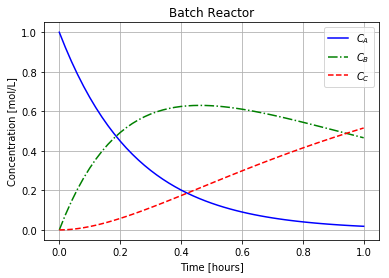

In [50]:
CA0 = 1 # Moles/L
k = [4, 1] # 1/hr

def exact_concentrations(t):
    ''' Exact solution for concentration profiles
    
    Arguments:
        t - time in hours (numpy array, length n)
        
    Returns:
        C: concentration of species A, B, and C in moles/L (3 x n numpy array)
    
    Important:
        This function assumes CA0 and k are defined in the global scope.
    
    '''

    CA = CA0 * np.exp(-k[0]*t);
    CB = k[0]*CA0/(k[1]-k[0]) * (np.exp(-k[0]*t) - np.exp(-k[1]*t));
    CC = CA0 - CA - CB;
    
    return np.vstack((CA, CB, CC))

def plot_concentrations(t,C):
    ''' Plot concentrations
    
    Arugments:
        C - matrix (3 x n numpy array) of concentrations
    
    '''
    
    
    
    plt.plot(t, C[0,:], label="$C_{A}$",linestyle="-",color="blue")
    plt.plot(t, C[1,:], label="$C_{B}$",linestyle="-.",color="green")
    plt.plot(t, C[2,:], label="$C_{C}$",linestyle="--",color="red")
    plt.xlabel("Time [hours]")
    plt.ylabel("Concentration [mol/L]")
    plt.title("Batch Reactor")
    plt.legend()
    plt.grid(True)
    plt.show()

t = np.linspace(0,1,51)
C = exact_concentrations(t)
plot_concentrations(t,C)

But let's say you did not know the analytic solution. We will now explore how to numerically approximate the solution.

### 12j-i. Linear Differential Equation System

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: With a partner, write the batch reactor differential equations as a linear system.
</div>

Let $\mathbf{y}(t) = [C_A(t), C_B(t), C_C(t)]$. Write the differential equations in the form:

$$ \mathbf{y}'(t) = \mathbf{A}(t) \mathbf{y} + \mathbf{c}(t), \qquad \mathbf{y}(0) = \mathbf{y}_0.$$

What is $\mathbf{A}$, $\mathbf{c}(t)$, and $\mathbf{y}_0$?

### 12j-ii. Linear Differential Equation System

We now need to define a Python function to compute the right-hand side (RHS) of the differential equation.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: With a partner, fill in the following functions. Define <tt>c0</tt>.
</div>

In [51]:
def A_rxn(t):
    ''' Matrix A for linear differential equations of reaction system
    
    Arguments:
        t: time (scalar)
        
    Returns:
        A: matrix (3 x 3)
    
    '''
    ### BEGIN SOLUTION
    return np.array([[-k[0], 0, 0], [k[0], -k[1], 0], [0, k[1], 0]])
    ### END SOLUTION
    
def c_rxn(t):
    ''' Forcing function for reaction system differential equation
    
    Arguments:
        t: time (scalar)
        
    Returns:
        c: vector (3 x 1)
    
    '''
    ### BEGIN SOLUTION
    return np.zeros(3)
    ### END SOLUTION

#c0 = 
### BEGIN SOLUTION
c0 = np.array([CA0, 0.0, 0.0])
### END SOLUTION
    
print("A =\n",A_rxn(0.0))

print("\nc =\n",c_rxn(0.0))

A =
 [[-4  0  0]
 [ 4 -1  0]
 [ 0  1  0]]

c =
 [0. 0. 0.]


### 12j-iii. Numerically Integrate using Class Implementation

In [52]:
Delta_t = 0.1
t_final = 1.0

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: With a partner, compare the numerical solutions with Forward Euler, Backward Euler, Crank-Nicolson, and Runge-Kutta.
</div>

#### Forward Euler

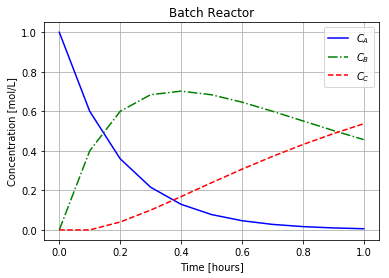

In [53]:
t_,C_ = forward_euler_system(A_rxn,c_rxn,c0,Delta_t,t_final/Delta_t)
plot_concentrations(t_,C_)

#### Backward Euler

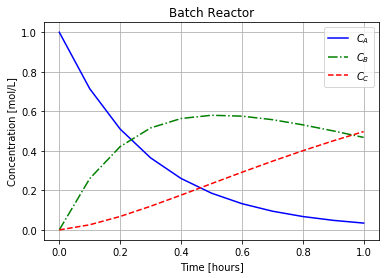

In [54]:
### BEGIN SOLUTION
t_,C_ = backward_euler_system(A_rxn,c_rxn,c0,Delta_t,t_final/Delta_t)
plot_concentrations(t_,C_)
### END SOLUTION

#### Crank-Nicolson

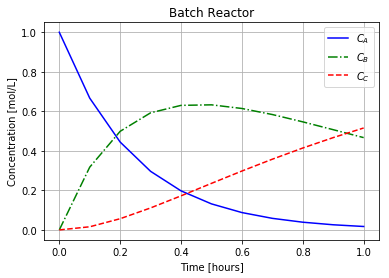

In [55]:
### BEGIN SOLUTION
t_,C_ = cn_system(A_rxn,c_rxn,c0,Delta_t,t_final/Delta_t)
plot_concentrations(t_,C_)
### END SOLUTION

#### Runge-Kutta

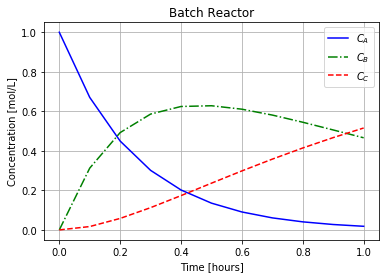

In [56]:
### BEGIN SOLUTION
t_,C_ = RK4_system(A_rxn,c_rxn,c0,Delta_t,t_final/Delta_t)
plot_concentrations(t_,C_)
### END SOLUTION

### 12j-iv. Numerically Integrate using Scipy